## BadNets

imports

In [1]:
import sys
sys.path.append("../attacks")
from PoisonedCIFAR10 import PoisonedCIFAR10
from bad_nets.BadNets import AddCIFAR10Trigger 
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import random
from torchvision import transforms
import os
from Data import Data
from auxiliary import format_time
import torch
from torch.utils.data import DataLoader, TensorDataset
import time
sys.path.append("../models_functions")
from resnet_functions import evaluate_model, load_model

# this is an example of how to use the BadNets attack

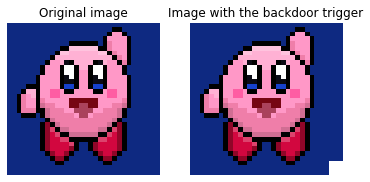

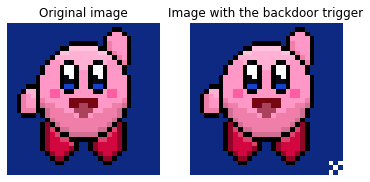

In [2]:
from attacks.bad_nets.BadNets import test_adding_trigger

path = "../resources/bad_nets"
square_pattern = Image.open(f"{path}/trigger_image.png")
grid_pattern = Image.open(f"{path}/trigger_image_grid.png")
test_image = Image.open(f"{path}/kirby.png").convert("RGB")

test_adding_trigger(test_image, AddCIFAR10Trigger(square_pattern), AddCIFAR10Trigger(grid_pattern))

these are all the classes in CIFAR10 dataset

In [3]:
classes = ("airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

this is the label we put on the poisoned images

In [4]:
poisoned_image_class = "airplane"

# first we load the dataset

In [5]:
from attacks.bad_nets.BadNets import load_CIFAR10_data
benign_root = "../datasets/CIFAR10/cifar-10"

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
batch_size = 4

trainset, trainloader, testset, testloader = load_CIFAR10_data(benign_root, batch_size, transform)

Files already downloaded and verified
Files already downloaded and verified


# then we create the add trigger function

In [6]:
add_square_trigger = AddCIFAR10Trigger(square_pattern)
add_grid_trigger = AddCIFAR10Trigger(grid_pattern)

# then we poison the dataset using the square trigger, setting the target class to airplane

In [7]:
poisoned_dataset = PoisonedCIFAR10(benign_dataset=trainset,
                                   y_target=classes.index(poisoned_image_class),
                                   poisoned_rate=0.05,
                                   poisoning_strategy=add_square_trigger)

Files already downloaded and verified


# this is the example of a poisoned CIFAR10 image

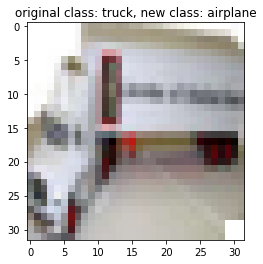

In [8]:
index = random.choice(list(poisoned_dataset.poisoned_indices))
image, label = poisoned_dataset[index]
plt.imshow(image)
plt.title(f"original class: {classes[poisoned_dataset.targets[index]]}, new class: {classes[label]}")
plt.show()

# we save the poisoned dataset

In [9]:
# poisoned_dataset.save("../datasets/CIFAR10/cifar-10/bad_nets/train")

# testing the model

In [10]:
weight_path = r"../models/badnets/resnet18_ckpt_square_05_percent.pth"
model_name = 'resnet18'

# test on clean data first
CLEAN_DIR = "../datasets/CIFAR10/cifar-10"
train_images = os.path.join(CLEAN_DIR, "train", "data.npy")
train_labels = os.path.join(CLEAN_DIR, "train", "labels.npy")
test_images = os.path.join(CLEAN_DIR, "test", "data.npy")
test_labels = os.path.join(CLEAN_DIR, "test", "labels.npy")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cifar_10_dataset= Data(train_images=train_images,train_labels=train_labels,
                     test_images=test_images,test_labels=test_labels)
cifar_10_dataset.normalize()
cifar_10_dataset.images_to_tensor()

train_data, train_labels, test_data, test_labels = cifar_10_dataset.permute_img_channels(permute_order=[0, 3, 1, 2])

test_dataset = TensorDataset(test_data, test_labels)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model = load_model(cifar_10_dataset.num_classes,model_name,device,pretrained=True)
state_dict = torch.load(weight_path)
model.load_state_dict(state_dict)

start_time = time.time() 
    
average_loss, accuracy = evaluate_model(model, test_loader, device)
print(f'Test Accuracy: {accuracy}%, average_loss: {average_loss}')

end_time = time.time() 
evaluating_time = end_time - start_time
formatted_evaluating_time = format_time(evaluating_time)
print(f"Evaluating time: {formatted_evaluating_time}")

c:\Users\sucic\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sucic\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.